<a href="https://colab.research.google.com/github/eunjiWon/SoftwareDefectPredictionMetricUsingDeepLearning/blob/master/Text_Generation_With_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation With Pytorch
  [https://machinetalk.org/2019/02/08/text-generation-with-pytorch/](https://machinetalk.org/2019/02/08/text-generation-with-pytorch/)
     

## Practice handling matrix with python language

In [0]:
# Read the file on google drive
from google.colab import drive
drive.mount('/content/gdrive')
# However, I failed to read the txt file

In [0]:
# Read the file on local
from google.colab import files
uploaded = files.upload()

In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
with open('/content/oliver_ch1.txt', 'r') as f:
  text = f.read()
print(len(text))

92031


In [0]:
# Create two dictionaries, one to convert words into integers indices, 
# and the other one to convert integer indices back to word tokens
word_counts = Counter(text)
print(word_counts)
sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print(sorted_vocab)
int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
print(int_to_vocab)
vocab_to_int = {w: k for k, w in int_to_vocab.items()}
print(vocab_to_int)
n_vocab = len(int_to_vocab)
print('Vocabulary size', n_vocab)



Counter({'OF': 2, 'THE': 2, 'which': 2, 'will': 2, 'to': 2, 'TREATS': 1, 'PLACE': 1, 'WHERE': 1, 'OLIVER': 1, 'TWIST': 1, 'WAS': 1, 'BORN': 1, 'AND': 1, 'CIRCUMSTANCES': 1, 'ATTENDING': 1, 'HIS': 1, 'BIRTH': 1, 'Among': 1, 'other': 1, 'public': 1, 'buildings': 1, 'in': 1, 'a': 1, 'certain': 1, 'town,': 1, 'for': 1, 'many': 1, 'reasons': 1, 'it': 1, 'be': 1, 'prudent': 1, 'refrain': 1, 'from': 1, 'mentioning,': 1, 'and': 1, 'I': 1, 'assign': 1, 'no': 1, 'fictitious': 1, 'name,': 1})
['OF', 'THE', 'which', 'will', 'to', 'TREATS', 'PLACE', 'WHERE', 'OLIVER', 'TWIST', 'WAS', 'BORN', 'AND', 'CIRCUMSTANCES', 'ATTENDING', 'HIS', 'BIRTH', 'Among', 'other', 'public', 'buildings', 'in', 'a', 'certain', 'town,', 'for', 'many', 'reasons', 'it', 'be', 'prudent', 'refrain', 'from', 'mentioning,', 'and', 'I', 'assign', 'no', 'fictitious', 'name,']
{0: 'OF', 1: 'THE', 2: 'which', 3: 'will', 4: 'to', 5: 'TREATS', 6: 'PLACE', 7: 'WHERE', 8: 'OLIVER', 9: 'TWIST', 10: 'WAS', 11: 'BORN', 12: 'AND', 13: 'CI

In [0]:
batch_size = 1
seq_size = 32
# Covert word tokens into integer indices. 
# These will be the input to the network
# We will train a mini-batch each iteration 
# so we split the data into batches evenly. 
# Chopping out the last uneven batch
int_text = [vocab_to_int[w] for w in text]
print(len(int_text))
num_batches = int(len(int_text) / (seq_size * batch_size))
print(num_batches)
in_text = int_text[:num_batches * batch_size * seq_size]
print(len(in_text))

# In next generation problem, 
# the target of each input word will be its consecutive wold,
# so we just shift the whole input data to the left by one step
out_text = np.zeros_like(in_text)
print("in_text: ", in_text)
print("in_text[1:]: ", in_text[1:]) # index 1부터 쭉
print("out_text[:-1]: ", len(out_text[:-1])) # size 31
out_text[:-1] = in_text[1:]
print("out_text[:-1]: ", out_text[:-1])
out_text[-1] = in_text[0]
in_text = np.reshape(in_text, (batch_size, -1))
out_text = np.reshape(out_text, (batch_size, -1))
print("in_text: ", in_text)
print("out_text: ", out_text)

45
1
32
in_text:  [5, 0, 1, 6, 7, 8, 9, 10, 11, 12, 0, 1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2, 25, 26, 27, 28, 3, 29, 30]
in_text[1:]:  [0, 1, 6, 7, 8, 9, 10, 11, 12, 0, 1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2, 25, 26, 27, 28, 3, 29, 30]
out_text[:-1]:  31
out_text[:-1]:  [ 0  1  6  7  8  9 10 11 12  0  1 13 14 15 16 17 18 19 20 21 22 23 24  2
 25 26 27 28  3 29 30]
in_text:  [[ 5  0  1  6  7  8  9 10 11 12  0  1 13 14 15 16 17 18 19 20 21 22 23 24
   2 25 26 27 28  3 29 30]]
out_text:  [[ 0  1  6  7  8  9 10 11 12  0  1 13 14 15 16 17 18 19 20 21 22 23 24  2
  25 26 27 28  3 29 30  5]]


## Dataset
We will split the raw text into word tokens since we want to train a word-based model.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace

flags = Namespace(
    train_file='/content/oliver_ch1.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64, # LSTM hidden size
    gradients_norm=5, # norm to clip gradients
    initial_words=['I', 'am'], # Initial words to start prediction from
    predict_top_k=5, # top k results ro sample word from
    checkpoint_path='checkpoint',
)

In [0]:
def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r') as f:
        text = f.read()
    text = text.split()
    # Create two dictionaries, one to convert words into integers indices, 
    # and the other one to convert integer indices back to word tokens
    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)
    print('Vocabulary size', n_vocab)
    
    # Covert word tokens into integer indices. 
    # These will be the input to the network
    # We will train a mini-batch each iteration 
    # so we split the data into batches evenly. 
    # Chopping out the last uneven batch
    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    
    # In next generation problem, 
    # the target of each input word will be its consecutive wold,
    # so we just shift the whole input data to the left by one step
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:] # in_text의 두번째 부터 out_text의 처음으로 복사
    out_text[-1] = in_text[0] # in_text의 처음을 out_text의 마지막으로 복사
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text
  
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

## Model
We need an embedding layer, an LSTM layer, and a dense layer, so here is the __init__ method.

In [0]:
class RNNModule(nn.Module):
  def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
    super(RNNModule, self).__init__()
    self.seq_size = seq_size
    self.lstm_size = lstm_size
    self.embedding = nn.Embedding(n_vocab, embedding_size)
    self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
    self.dense = nn.Linear(lstm_size, n_vocab)

  # Take an input sequence and the previous states (hidden states) and produce the output together with states of the currents timestamp
  def forward(self, x, prev_state):
    embed = self.embedding(x)
    output, state = self.lstm(embed, prev_state)
    logits = self.dense(output)
    return logits, state # why return state variable?
  
  # Define one more method to help us set states to zero because we need to reset states at the beginning of every epoch.
  def zero_state(self, batch_size):
    return (torch.zeros(1, batch_size, self.lstm_size), # hidden state (the short-term memory)
            torch.zeros(1, batch_size, self.lstm_size)) # cell state (the long-term memory)


NameError: ignored

## Loss
We need a loss function and a training operation.

In [0]:
def get_loss_and_train_op(net, lr=0.001):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  return criterion, optimizer
  # gradient clipping doesn't apply here!


## Training


In [0]:
def main():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
      flags.train_file, flags.batch_size, flags.seq_size)
  net = RNNModule(n_vocab, flags.seq_size, flags.embedding_size, flags.lstm_size)
  net = net.to(device)
  criterion, optimizer = get_loss_and_train_op(net, 0.01)
  iteration = 0
  
  # for each epoch, we will loop through the batches to compute loss valuse and update network's parameters.
  for e in range(50):
    batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
    state_h, state_c = net.zero_state(flags.batch_size)
    
    # Transfer data to GPU
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for x, y in batches: # x is in_text and y is out_text
      iteration += 1
      
      # Tell it we are in training mode
      net.train()

      # Reset all gradients
      optimizer.zero_grad()

      # Transfer data to GPU
      x = torch.tensor(x).to(device)
      y = torch.tensor(y).to(device)

      logits, (state_h, state_c) = net(x, (state_h, state_c))
      loss = criterion(logits.transpose(1, 2), y) # why we transpose the logits?
      
      # Avoid autograd which is given by Pytorch to keep track of the tensor's flow to perform back-propagation.
      state_h = state_h.detach()
      state_c = state_c.detach()

      loss_value = loss.item() # this loss is cross-entropy which is thing I want!!! 
      
      # Perform back-propagation
      loss.backward()
      
      # Gradient clipping
      _ = torch.nn.utils.clip_grad_norm_(net.parameters(), flags.gradients_norm)


      # Update the network's parameters
      optimizer.step()

      # Print the loss value and have the model generate some text for us during training
      if iteration % 100 == 0:
        print('Epoch: {}/{}'.format(e, 200), 'Iteration: {}'.format(iteration), 'Loss (C.E): {}'.format(loss_value))

      if iteration % 1000 == 0:
        predict(device, net, flags.initial_words, n_vocab, vocab_to_int, int_to_vocab, top_k=5)
        torch.save(net.state_dict(), 'checkpoint_pt/model-{}.pth'.format(iteration))


In [0]:
# 1000번 마다 실제 테스트 데이터로 예측하는건가? Google it!
def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
  net.eval() # 모델을 훈련할 땐 model.train(), 테스트할 땐 model.eval() 함수를 호출하면 Module 클래스의 훈련 상태 여부를 바꾸게 되며 이는 dropout 같은 함수가 드롭아웃을 적용할지 안할지를 결정하게 만듭니다.
  
  state_h, state_c = net.zero_state(1)
  state_h = state_h.to(device)
  state_c = state_c.to(device)
  for w in words:
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, (state_h, state_c) = net(ix, (state_h, state_c))

  _, top_ix = torch.topk(output[0], k=top_k)
  choices = top_ix.tolist()
  choice = np.random.choice(choices[0])

  words.append(int_to_vocab[choice])

  for _ in range(100):
    ix = torch.tensor([[choice]]).to(device)
    output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])
    words.append(int_to_vocab[choice])

    print(' '.join(words).encode('utf-8'))

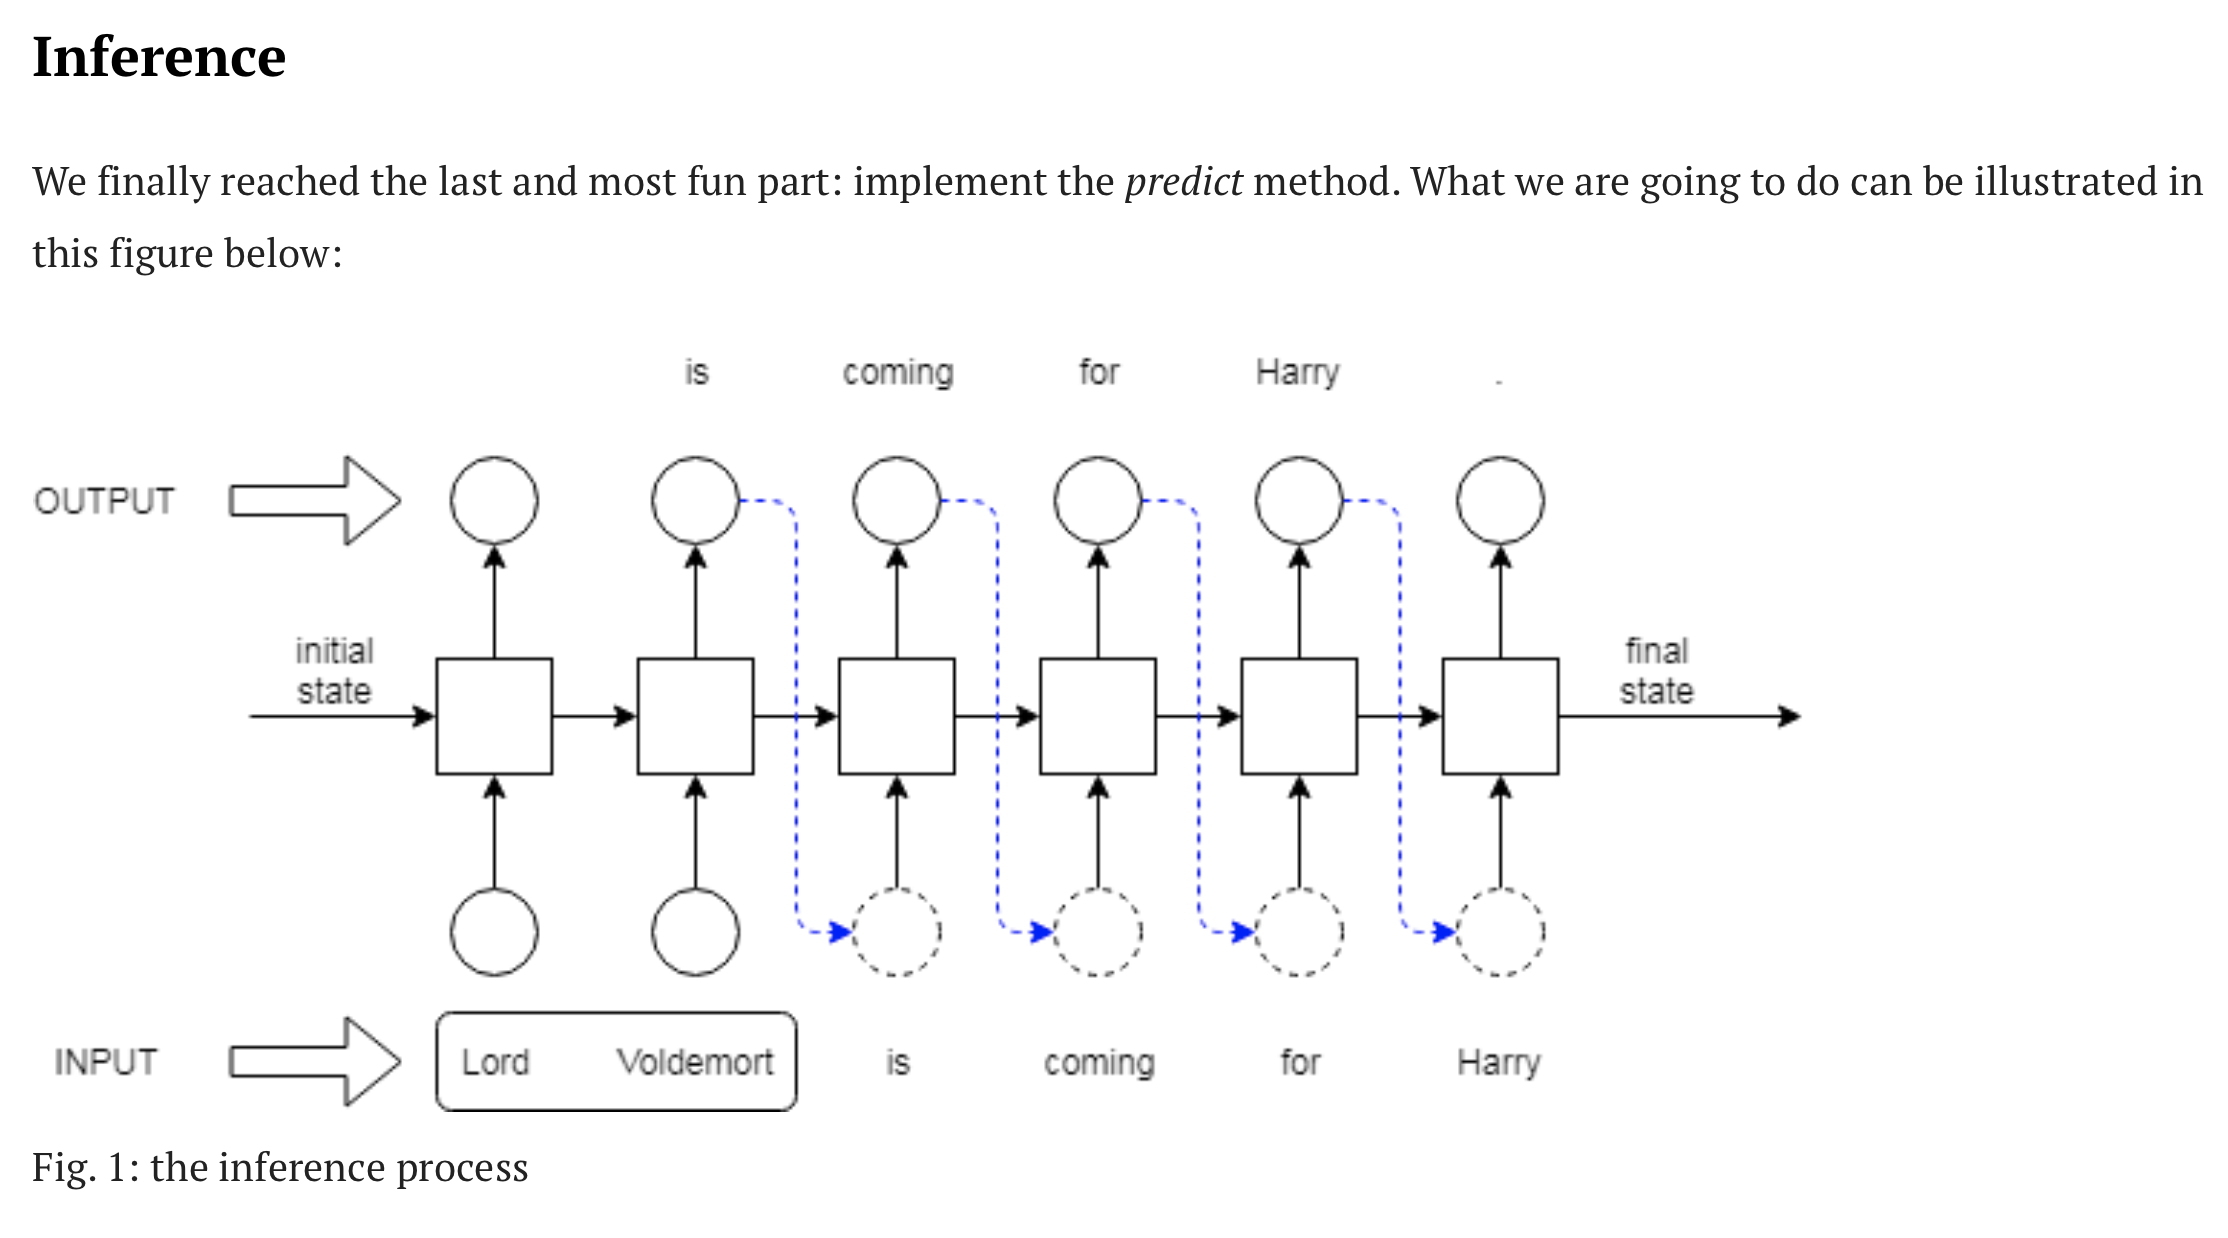

In [0]:
if __name__ == '__main__':
  main()

## Executable Code

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from collections import Counter
import os
from argparse import Namespace

flags = Namespace(
    train_file='/content/oliver_ch1.txt',
    seq_size=32,
    batch_size=16,
    embedding_size=64,
    lstm_size=64, # LSTM hidden size
    gradients_norm=5, # norm to clip gradients
    initial_words=['I', 'am'], # Initial words to start prediction from
    predict_top_k=5, # top k results ro sample word from
    checkpoint_path='checkpoint',
)

def get_data_from_file(train_file, batch_size, seq_size):
    with open(train_file, 'r') as f:
        text = f.read()
    text = text.split()
    # Create two dictionaries, one to convert words into integers indices, 
    # and the other one to convert integer indices back to word tokens
    word_counts = Counter(text)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {k: w for k, w in enumerate(sorted_vocab)}
    vocab_to_int = {w: k for k, w in int_to_vocab.items()}
    n_vocab = len(int_to_vocab)
    print('Vocabulary size', n_vocab)
    
    # Covert word tokens into integer indices. 
    # These will be the input to the network
    # We will train a mini-batch each iteration 
    # so we split the data into batches evenly. 
    # Chopping out the last uneven batch
    int_text = [vocab_to_int[w] for w in text]
    num_batches = int(len(int_text) / (seq_size * batch_size))
    in_text = int_text[:num_batches * batch_size * seq_size]
    
    # In next generation problem, 
    # the target of each input word will be its consecutive wold,
    # so we just shift the whole input data to the left by one step
    out_text = np.zeros_like(in_text)
    out_text[:-1] = in_text[1:] # in_text의 두번째 부터 out_text의 처음으로 복사
    out_text[-1] = in_text[0] # in_text의 처음을 out_text의 마지막으로 복사
    in_text = np.reshape(in_text, (batch_size, -1))
    out_text = np.reshape(out_text, (batch_size, -1))
    return int_to_vocab, vocab_to_int, n_vocab, in_text, out_text
  
def get_batches(in_text, out_text, batch_size, seq_size):
    num_batches = np.prod(in_text.shape) // (seq_size * batch_size)
    for i in range(0, num_batches * seq_size, seq_size):
        yield in_text[:, i:i+seq_size], out_text[:, i:i+seq_size]

class RNNModule(nn.Module):
  def __init__(self, n_vocab, seq_size, embedding_size, lstm_size):
    super(RNNModule, self).__init__()
    self.seq_size = seq_size
    self.lstm_size = lstm_size
    self.embedding = nn.Embedding(n_vocab, embedding_size)
    self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
    self.dense = nn.Linear(lstm_size, n_vocab)

  # Take an input sequence and the previous states (hidden states) and produce the output together with states of the currents timestamp
  def forward(self, x, prev_state):
    embed = self.embedding(x)
    output, state = self.lstm(embed, prev_state)
    logits = self.dense(output)
    return logits, state # why return state variable?
  
  # Define one more method to help us set states to zero because we need to reset states at the beginning of every epoch.
  def zero_state(self, batch_size):
    return (torch.zeros(1, batch_size, self.lstm_size), # hidden state (the short-term memory)
            torch.zeros(1, batch_size, self.lstm_size)) # cell state (the long-term memory)

def get_loss_and_train_op(net, lr=0.001):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  return criterion, optimizer
  # gradient clipping doesn't apply here!

def main():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  int_to_vocab, vocab_to_int, n_vocab, in_text, out_text = get_data_from_file(
      flags.train_file, flags.batch_size, flags.seq_size)
  net = RNNModule(n_vocab, flags.seq_size, flags.embedding_size, flags.lstm_size)
  net = net.to(device)
  criterion, optimizer = get_loss_and_train_op(net, 0.01)
  iteration = 0
  
  # for each epoch, we will loop through the batches to compute loss valuse and update network's parameters.
  for e in range(50):
    batches = get_batches(in_text, out_text, flags.batch_size, flags.seq_size)
    state_h, state_c = net.zero_state(flags.batch_size)
    
    # Transfer data to GPU
    state_h = state_h.to(device)
    state_c = state_c.to(device)
    for x, y in batches: # x is in_text and y is out_text
      iteration += 1
      
      # Tell it we are in training mode
      net.train()

      # Reset all gradients
      optimizer.zero_grad()

      # Transfer data to GPU
      x = torch.tensor(x).to(device)
      y = torch.tensor(y).to(device)

      logits, (state_h, state_c) = net(x, (state_h, state_c))
      loss = criterion(logits.transpose(1, 2), y) # why we transpose the logits?
      
      # Avoid autograd which is given by Pytorch to keep track of the tensor's flow to perform back-propagation.
      state_h = state_h.detach()
      state_c = state_c.detach()

      loss_value = loss.item() # this loss is cross-entropy which is thing I want!!! 
      
      # Perform back-propagation
      loss.backward()
      
      # Gradient clipping
      _ = torch.nn.utils.clip_grad_norm_(net.parameters(), flags.gradients_norm)


      # Update the network's parameters
      optimizer.step()

      # Print the loss value and have the model generate some text for us during training
      if iteration % 100 == 0:
        print('Epoch: {}/{}'.format(e, 200), 'Iteration: {}'.format(iteration), 'Loss (C.E): {}'.format(loss_value))

      if iteration % 1000 == 0:
        predict(device, net, flags.initial_words, n_vocab, vocab_to_int, int_to_vocab, top_k=5)
        # torch.save(net.state_dict(), 'checkpoint_pt/model-{}.pth'.format(iteration))

# 1000번 마다 실제 테스트 데이터로 예측하는건가? Google it!
def predict(device, net, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
  net.eval() # 모델을 훈련할 땐 model.train(), 테스트할 땐 model.eval() 함수를 호출하면 Module 클래스의 훈련 상태 여부를 바꾸게 되며 이는 dropout 같은 함수가 드롭아웃을 적용할지 안할지를 결정하게 만듭니다.
  
  state_h, state_c = net.zero_state(1)
  state_h = state_h.to(device)
  state_c = state_c.to(device)
  for w in words:
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, (state_h, state_c) = net(ix, (state_h, state_c))

  _, top_ix = torch.topk(output[0], k=top_k)
  choices = top_ix.tolist()
  choice = np.random.choice(choices[0])

  words.append(int_to_vocab[choice])

  for _ in range(100):
    ix = torch.tensor([[choice]]).to(device)
    output, (state_h, state_c) = net(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])
    words.append(int_to_vocab[choice])

    print(' '.join(words).encode('utf-8'))

if __name__ == '__main__':
  main()




Vocabulary size 4694
Epoch: 3/200 Iteration: 100 Loss (C.E): 5.780049800872803
Epoch: 6/200 Iteration: 200 Loss (C.E): 4.349148750305176
Epoch: 9/200 Iteration: 300 Loss (C.E): 3.151026964187622
Epoch: 12/200 Iteration: 400 Loss (C.E): 2.4220921993255615
Epoch: 16/200 Iteration: 500 Loss (C.E): 2.0293266773223877
Epoch: 19/200 Iteration: 600 Loss (C.E): 1.8780072927474976
Epoch: 22/200 Iteration: 700 Loss (C.E): 1.4044948816299438
Epoch: 25/200 Iteration: 800 Loss (C.E): 1.135439157485962
Epoch: 29/200 Iteration: 900 Loss (C.E): 0.8055417537689209
Epoch: 32/200 Iteration: 1000 Loss (C.E): 0.8591955900192261
b'I am his head'
b'I am his head prevented'
b'I am his head prevented now'
b'I am his head prevented now hope'
b'I am his head prevented now hope even'
b'I am his head prevented now hope even with'
b'I am his head prevented now hope even with astonishment.'
b'I am his head prevented now hope even with astonishment. to'
b'I am his head prevented now hope even with astonishment. to lo